In [1]:
import os
import glob
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/captain/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare data
- Concat patient №3 data into one dataframe
- Downsample to 1Hz (one datapoint per second)
- Restructure dataframe: add next second etSEV as a target variable
- Standart scale the data

In [2]:
case_fulldata = glob.glob("../../data/uqvitalsignsdata/case03/fulldata/**")

a = pd.read_csv(case_fulldata[0], error_bad_lines=False, nrows=2)
names = a.columns.values
# names = ['HR', 'SpO2', 'etCO2', 'NBP (Mean)', 'etSEV', 'inSEV', 'inO2', 'RR']
names = [3, 6, 8, 13, 23, 24, 29, 36]
df = pd.read_csv(case_fulldata[0], usecols=names)
df.describe()

,HR,SpO2,etCO2,NBP (Mean),etSEV,inSEV,inO2,RR
count,60000.00000,60000.000000,60000.000000,54574.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,71.56555,99.644250,35.734283,66.331348,2.095912,2.747669,53.736467,10.782283
std,6.38237,0.478744,0.554782,13.451704,0.046210,0.052909,0.440553,0.931037
min,57.00000,99.000000,34.000000,54.000000,2.000000,2.700000,53.000000,10.000000
25%,67.00000,99.000000,35.000000,59.000000,2.050000,2.700000,53.000000,10.000000
50%,72.00000,100.000000,36.000000,60.000000,2.100000,2.750000,54.000000,11.000000
75%,76.00000,100.000000,36.000000,87.000000,2.100000,2.750000,54.000000,11.000000
max,88.00000,100.000000,37.000000,87.000000,2.200000,3.000000,54.000000,14.000000


In [3]:
all_rows = pd.DataFrame()

for f in case_fulldata:
    df = pd.read_csv(f, usecols=names, index_col=False)
    df = df.fillna(0)

    all_rows = all_rows.append(df)

all_rows = all_rows[::100] # downsample to 1Hz
    
all_rows.head()


,HR,SpO2,etCO2,NBP (Mean),etSEV,inSEV,inO2,RR
0,78.0,99.0,36,87.0,2.2,3.0,53,11
100,77.0,99.0,36,87.0,2.2,3.0,53,11
200,77.0,99.0,36,87.0,2.2,3.0,53,11
300,77.0,100.0,36,87.0,2.2,3.0,53,11
400,76.0,100.0,36,87.0,2.2,3.0,53,11


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns.values[j], i)) for j in range(n_vars)]
    # forecast sequency (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns.values[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns.values[j], i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
doubled_df = series_to_supervised(all_rows).reset_index(drop=True)
doubled_df.describe()

,HR(t-1),SpO2(t-1),etCO2(t-1),NBP (Mean)(t-1),etSEV(t-1),inSEV(t-1),inO2(t-1),RR(t-1),HR(t),SpO2(t),etCO2(t),NBP (Mean)(t),etSEV(t),inSEV(t),inO2(t),RR(t)
count,14985.000000,14985.000000,14985.00000,14985.000000,14985.000000,14985.00000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000
mean,61.987988,98.121388,33.05025,56.422956,1.875322,2.22302,60.753420,10.420754,61.987187,98.121455,33.049983,56.421221,1.875322,2.223000,60.753487,10.420687
std,19.210112,11.738947,4.84306,23.962399,0.591648,0.83258,14.782806,2.375042,19.209695,11.738955,4.843008,23.961126,0.591648,0.832565,14.782773,2.375040
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000
25%,64.000000,99.000000,32.00000,60.000000,1.850000,2.35000,54.000000,10.000000,64.000000,99.000000,32.000000,60.000000,1.850000,2.350000,54.000000,10.000000
50%,67.000000,100.000000,33.00000,64.000000,2.100000,2.40000,54.000000,10.000000,67.000000,100.000000,33.000000,64.000000,2.100000,2.400000,54.000000,10.000000
75%,70.000000,100.000000,35.00000,67.000000,2.200000,2.70000,56.000000,10.000000,70.000000,100.000000,35.000000,67.000000,2.200000,2.700000,56.000000,10.000000
max,98.000000,100.000000,47.00000,87.000000,4.200000,4.20000,98.000000,27.000000,98.000000,100.000000,47.000000,87.000000,4.200000,4.200000,98.000000,27.000000


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

df = doubled_df.drop(doubled_df.columns[[8, 9, 10, 11, 12, 13, 14, 15]], axis=1).reset_index(drop=True)
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index) 
df['target'] = doubled_df[doubled_df.columns[[12]]]
df.describe()

,HR(t-1),SpO2(t-1),etCO2(t-1),NBP (Mean)(t-1),etSEV(t-1),inSEV(t-1),inO2(t-1),RR(t-1),target
count,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000,14985.000000
mean,0.632530,0.981214,0.703197,0.648540,0.446505,0.529290,0.357818,0.385954,1.875322
std,0.196022,0.117389,0.103044,0.275430,0.140869,0.198233,0.254876,0.087965,0.591648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.653061,0.990000,0.680851,0.689655,0.440476,0.559524,0.241379,0.370370,1.850000
50%,0.683673,1.000000,0.702128,0.735632,0.500000,0.571429,0.241379,0.370370,2.100000
75%,0.714286,1.000000,0.744681,0.770115,0.523810,0.642857,0.275862,0.370370,2.200000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.200000


In [6]:
df.head()

,HR(t-1),SpO2(t-1),etCO2(t-1),NBP (Mean)(t-1),etSEV(t-1),inSEV(t-1),inO2(t-1),RR(t-1),target
0,0.795918,0.99,0.765957,1.0,0.52381,0.714286,0.224138,0.407407,2.2
1,0.785714,0.99,0.765957,1.0,0.52381,0.714286,0.224138,0.407407,2.2
2,0.785714,0.99,0.765957,1.0,0.52381,0.714286,0.224138,0.407407,2.2
3,0.785714,1.00,0.765957,1.0,0.52381,0.714286,0.224138,0.407407,2.2
4,0.775510,1.00,0.765957,1.0,0.52381,0.714286,0.224138,0.407407,2.2


In [7]:
X, y = df.values[:, :-1].astype(np.float64), df.values[:, -1].astype(np.float64)

TRAIN_SIZE = int(len(X) * 0.7)

X_train, X_test, y_train, y_test = X[:TRAIN_SIZE], X[TRAIN_SIZE:], y[:TRAIN_SIZE], y[TRAIN_SIZE:]

X_train.shape, X_test.shape

((10489, 8), (4496, 8))

# Linear regression

## Training

In [8]:
from tensorflow.estimator import LinearRegressor
from tensorflow.feature_column import numeric_column
from tensorflow.estimator.inputs import numpy_input_fn

COLUMNS = [col.replace(' ', '').replace('(', '').replace(')', '') for col in all_rows.columns.values]

feature_columns = [numeric_column(col) for col in COLUMNS] # dtype == float32, because float64 cannot be exported
tfreg = LinearRegressor(
    feature_columns,
)

tfreg.train(
    numpy_input_fn(
        {col: X_train[:, i] for i, col in enumerate(COLUMNS)},
        y=y_train[:],
        shuffle=False,
        batch_size=16, 
        num_epochs=20
    )
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/pz/3lrslqj14yxc8l14zc224w0w0000gn/T/tmplemulhuf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xd3dd0a7f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for 

INFO:tensorflow:global_step/sec: 382.077
INFO:tensorflow:loss = 0.0024753676, step = 5801 (0.262 sec)
INFO:tensorflow:global_step/sec: 430.884
INFO:tensorflow:loss = 0.0052906703, step = 5901 (0.233 sec)
INFO:tensorflow:global_step/sec: 401.143
INFO:tensorflow:loss = 0.0027778493, step = 6001 (0.247 sec)
INFO:tensorflow:global_step/sec: 331.297
INFO:tensorflow:loss = 0.016024549, step = 6101 (0.302 sec)
INFO:tensorflow:global_step/sec: 364.401
INFO:tensorflow:loss = 0.0034104092, step = 6201 (0.275 sec)
INFO:tensorflow:global_step/sec: 385.576
INFO:tensorflow:loss = 0.003992593, step = 6301 (0.260 sec)
INFO:tensorflow:global_step/sec: 206.415
INFO:tensorflow:loss = 0.04567734, step = 6401 (0.485 sec)
INFO:tensorflow:global_step/sec: 323.517
INFO:tensorflow:loss = 0.071039736, step = 6501 (0.308 sec)
INFO:tensorflow:global_step/sec: 224.706
INFO:tensorflow:loss = 0.015636187, step = 6601 (0.446 sec)
INFO:tensorflow:global_step/sec: 351.114
INFO:tensorflow:loss = 0.00033581167, step = 67

## Evaluating

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/pz/3lrslqj14yxc8l14zc224w0w0000gn/T/tmplemulhuf/model.ckpt-13112
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-07-21:41:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/pz/3lrslqj14yxc8l14zc224w0w0000gn/T/tmplemulhuf/model.ckpt-13112
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-07-21:41:09
INFO:tensorflow:Saving dict for global step 13112: average_loss = 0.0042873863, global_step = 13112, label/mean = 2.0511758, loss = 0.0042873863, prediction/mean = 2.0060713
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13112: /var/folde

{'average_loss': 0.0042873863,
 'label/mean': 2.0511758,
 'loss': 0.0042873863,
 'prediction/mean': 2.0060713,
 'global_step': 13112}

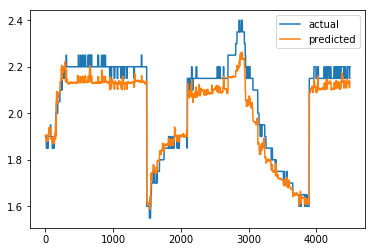

In [10]:
test_inp = numpy_input_fn(
        {col: X_test[:, i] for i, col in enumerate(COLUMNS)},
        y_test,
        shuffle=False,
        batch_size=1
)

pred_gen = tfreg.predict(test_inp)
preds = np.array([pred['predictions'][0] for pred in pred_gen])


plt.plot(range(len(X_test)), y_test, label='actual')
plt.plot(range(len(X_test)), preds, label='predicted')
plt.legend()

tfreg.evaluate(test_inp)



# Export

In [11]:
rec = tf.estimator.export.build_parsing_serving_input_receiver_fn(
    tf.feature_column.make_parse_example_spec(feature_columns)
)
model_dir = tfreg.export_saved_model("../export", serving_input_receiver_fn=rec, as_text=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['serving_default', 'regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /var/folders/pz/3lrslqj14yxc8l14zc224w0w0000gn/T/tmplemulhuf/model.ckpt-13112
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../export/temp-b'1554673286'/saved_model.pbtxt


In [12]:
from tensorflow.contrib import predictor

p = predictor.from_saved_model(model_dir)
p.feed_tensors, p.fetch_tensors

INFO:tensorflow:Restoring parameters from ../export/1554673286/variables/variables


({'inputs': <tf.Tensor 'input_example_tensor:0' shape=(?,) dtype=string>},
 {'outputs': <tf.Tensor 'linear/linear_model/linear_model/weighted_sum:0' shape=(?, 1) dtype=float32>})

In [13]:
feature = {}
for col, value in zip(COLUMNS, X_test[0]):
    feature[col] = tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
example = tf.train.Example(
    features=tf.train.Features(
        feature=feature
    )
)

p({'inputs':[example.SerializeToString()]})


{'outputs': array([[1.9061096]], dtype=float32)}

In [14]:
X_test[0], y_test[0]

(array([0.73469388, 1.        , 0.80851064, 0.77011494, 0.45238095,
        0.5952381 , 0.24137931, 0.37037037]), 1.9)